In [26]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [27]:
import cufflinks as cf

from plotly.offline import download_plotlyjs, init_notebook_mode

init_notebook_mode(connected=True)

cf.go_offline()

In [28]:
df = pd.read_csv("data/dataset_B_05_2020.csv")

In [29]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [30]:
print(df.shape)

(11430, 89)


### Observations
- No null value
- No duplicate values
- Have columns with only one unique values (They have no impact) 

In [31]:
print("NAN :", df.isna().values.sum())
print("Duplicates :", df.duplicated().values.sum())

NAN : 0
Duplicates : 0


In [32]:
df.nunique().values

array([11429,   324,    83,     2,    19,    27,     5,     4,    15,
           1,    16,    17,     2,    25,    22,     2,     6,     5,
          15,     5,     9,     3,     7,     2,     5,     2,  1414,
         241,     2,     2,     2,     2,     2,     3,     2,     2,
           2,     2,     7,     2,    54,    55,    25,    34,    33,
         119,    49,   120,   896,   174,   757,     9,     2,     2,
           2,     2,     3,   691,  3131,  3131,     1,    33,     1,
         894,     1,   635,     2,     2,   473,     1,   490,   490,
           1,     2,     2,  1083,     2,     2,     2,     2,     2,
           2,  1659,  4430,  4744,     2,     2,    11,     2],
      dtype=int64)

In [33]:
single_val_col = [var for var in list(df.columns) if df[var].nunique() == 1]
single_val_col.append("url")

In [34]:
# Droping the colums with unique value less than one
df.drop(columns=single_val_col, inplace=True)

In [35]:
# OHE status
df = pd.get_dummies(data=df, columns=['status'], drop_first=True)

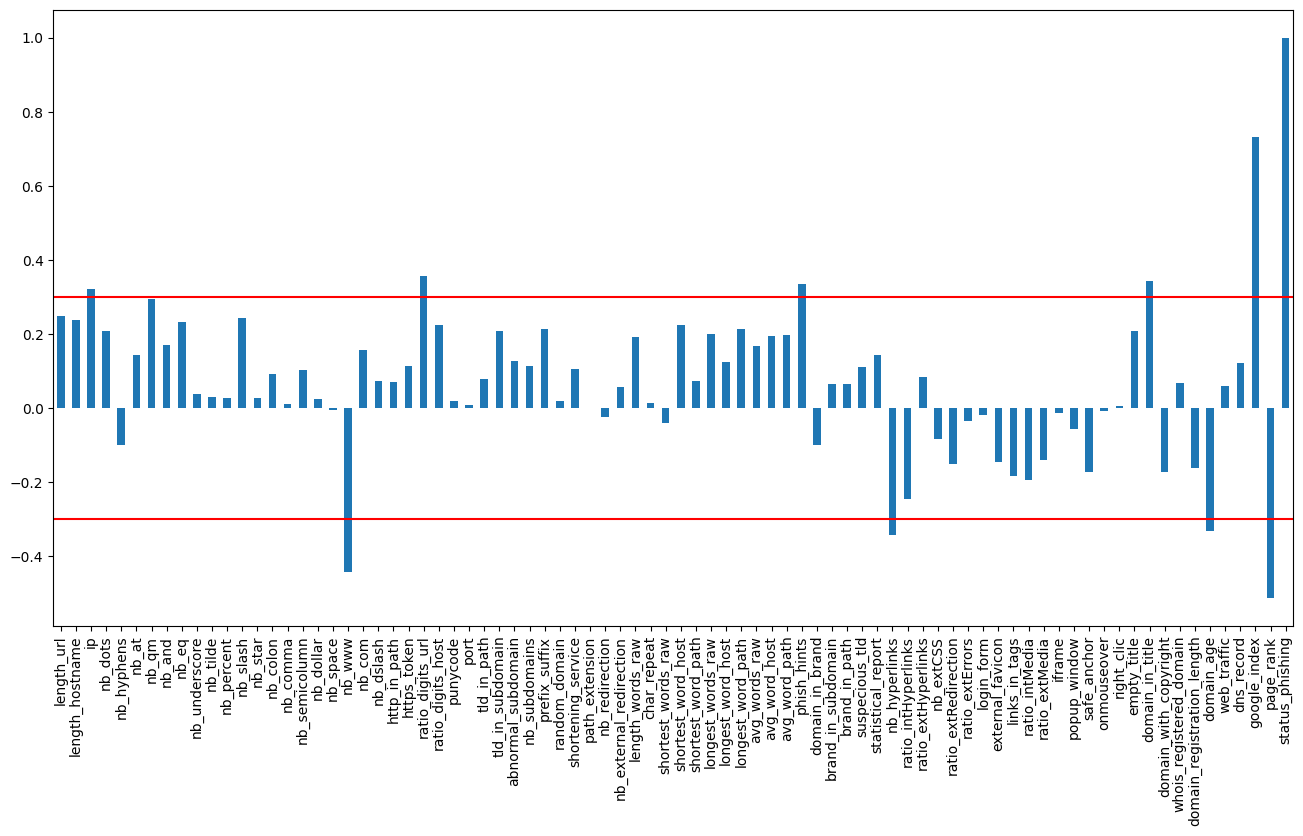

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot correlation
corr = df.corr()['status_phishing']
corr.plot(kind='bar', figsize=(16, 8))


plt.axhline(y=0.3, color='red')
plt.axhline(y=-0.3, color='red')


plt.show()


plt.savefig('correlation_plot.png')

### Feature Selection

In [37]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [38]:
X = df.drop(columns=['status_phishing'])
y = df['status_phishing']

In [39]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

sel_.fit(X, y)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [40]:
sel_.get_support().sum()

50

In [41]:
selected_feats = X.columns[(sel_.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 81
selected features: 50
features with coefficients shrank to zero: 29


In [42]:
selected_feats

Index(['length_url', 'length_hostname', 'ip', 'nb_hyphens', 'nb_qm', 'nb_and',
       'nb_eq', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_colon',
       'nb_space', 'nb_www', 'nb_com', 'http_in_path', 'https_token',
       'ratio_digits_host', 'prefix_suffix', 'shortening_service',
       'nb_redirection', 'length_words_raw', 'char_repeat',
       'shortest_words_raw', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'suspecious_tld', 'nb_hyperlinks', 'ratio_extHyperlinks', 'nb_extCSS',
       'ratio_extRedirection', 'external_favicon', 'links_in_tags',
       'ratio_intMedia', 'ratio_extMedia', 'safe_anchor', 'empty_title',
       'domain_in_title', 'domain_with_copyright', 'whois_registered_domain',
       'domain_registration_length', 'dns_record', 'google_index',
       'page_rank'],
      dtype='object')

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X = df[selected_feats]

In [82]:
y = df['status_phishing']

In [101]:
y.value_counts()

0    5715
1    5715
Name: status_phishing, dtype: int64

In [84]:
X.shape, y.shape

((11430, 50), (11430,))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train.shape, X_test.shape

((9144, 50), (2286, 50))

In [87]:
y_train.shape, y_test.shape

((9144,), (2286,))

In [89]:
import tensorflow
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import L2

In [91]:
model = Sequential()

model.add(Dense(128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [92]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1, batch_size=128)

Epoch 1/30
65/65 [==============================] - 1s 6ms/step - loss: 1.7166 - accuracy: 0.7170 - val_loss: 0.5505 - val_accuracy: 0.8164
Epoch 2/30
65/65 [==============================] - 0s 4ms/step - loss: 0.5547 - accuracy: 0.7841 - val_loss: 0.3993 - val_accuracy: 0.8328
Epoch 3/30
65/65 [==============================] - 0s 5ms/step - loss: 0.4204 - accuracy: 0.8132 - val_loss: 0.3985 - val_accuracy: 0.8317
Epoch 4/30
65/65 [==============================] - 0s 5ms/step - loss: 0.3996 - accuracy: 0.8262 - val_loss: 0.3692 - val_accuracy: 0.8481
Epoch 5/30
65/65 [==============================] - 0s 4ms/step - loss: 0.3441 - accuracy: 0.8544 - val_loss: 0.4962 - val_accuracy: 0.8098
Epoch 6/30
65/65 [==============================] - 0s 4ms/step - loss: 0.3315 - accuracy: 0.8599 - val_loss: 0.3207 - val_accuracy: 0.8634
Epoch 7/30
65/65 [==============================] - 0s 5ms/step - loss: 0.3029 - accuracy: 0.8760 - val_loss: 0.3412 - val_accuracy: 0.8568
Epoch 8/30
65/65 [==

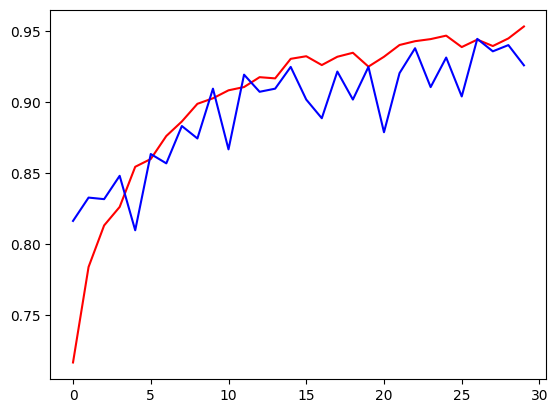

In [93]:
plt.plot(history.history['accuracy'], color='r') 
plt.plot(history.history['val_accuracy'], color='b') 

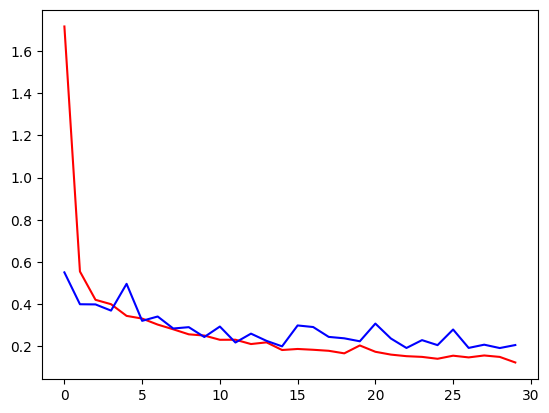

In [94]:
plt.plot(history.history['loss'], color='r') 
plt.plot(history.history['val_loss'], color='b') 

In [103]:
pred_train_prob = model.predict(X_train)
pred_test_prob = model.predict(X_test)

72/72 [==============================] - 0s 2ms/step


In [106]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Predction for Test data

In [104]:
test_pred = np.where(pred_test_prob > 0.5, 1, 0)

In [105]:
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1137
           1       0.95      0.93      0.94      1149

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



In [108]:
confusion_matrix(test_pred, y_test)

array([[1077,   60],
       [  80, 1069]], dtype=int64)

In [116]:
accuracy_score(test_pred, y_test)

0.9387576552930884

### Predition on Train Data

In [109]:
train_pred = np.where(pred_train_prob > 0.5, 1, 0)

In [111]:
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4481
           1       0.96      0.95      0.95      4663

    accuracy                           0.95      9144
   macro avg       0.95      0.95      0.95      9144
weighted avg       0.95      0.95      0.95      9144



In [112]:
confusion_matrix(train_pred, y_train)

array([[4304,  177],
       [ 254, 4409]], dtype=int64)

In [113]:
accuracy_score(train_pred, y_train)

0.9528652668416447